In [108]:
%%capture
#@title Instalamos gym
!pip install swig
!pip install "gymnasium[box2d]"
!pip install numpy
!pip install matplotlib
!pip install tqdm
#!pip install "gymnasium[toy-text]"
!pip install Box2D
!pip install pygame


In [109]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import Box2D
import random

In [110]:
#@title Importamos el lago helado
name = 'Taxi-v3'

# Creamos el entorno Taxi-v3
env = gym.make("FrozenLake-v1", render_mode="rgb_array")


In [111]:
import numpy as np
from collections import defaultdict
import random

class QLearningAgent:
    def __init__(self, env, eps=0.1, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state):
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            Qsa_next = np.max(self.Q[next_state])
        
        # Q-learning update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [112]:
import numpy as np
from collections import defaultdict
import random

class SarsaAgent:
    def __init__(self, env, eps=0.1, gamma=0.99, alpha=0.2):
        """Initialize agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        self.alpha = alpha
        
        # Initialize Q-table based on action space, not observation space
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action with probability 1-epsilon
            return np.argmax(self.Q[state])
        else:  # select random action with probability epsilon
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state):
        """Select an action given the current state."""
        return self.epsilon_greedy(state)
    
    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.
        
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]
        
        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            next_action = self.epsilon_greedy(next_state)
            Qsa_next = self.Q[next_state][next_action]
        
        # Sarsa update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

In [113]:
import numpy as np
from collections import defaultdict
import random

class MCOnPolicyAgent:
    def __init__(self, env, eps=0.1, gamma=0.99):
        """Initialize Monte Carlo agent.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        
        # Initialize Q-table and returns dictionary
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(list)  # Stores returns for (state, action) pairs
        
    def epsilon_greedy(self, state):
        """Epsilon-greedy action selection."""
        if random.random() > self.eps:  # select greedy action
            return np.argmax(self.Q[state])
        else:  # select random action
            return random.randint(0, self.env.action_space.n - 1)
    
    def get_action(self, state):
        """Select an action given the current state."""
        return self.epsilon_greedy(state)

    def update(self, episode):
        """Update Q-values using Monte Carlo method.
        
        Params
        ======
        - episode: List of (state, action, reward) tuples from one episode
        """
        G = 0  # Return
        visited = set()  # Track (state, action) pairs we have already seen in this episode

        # Process episode in reverse order
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G  # Discounted return

            # Only update the first time (state, action) is encountered in the episode
            if (state, action) not in visited:
                visited.add((state, action))
                self.returns[(state, action)].append(G)  # Store return
                self.Q[state][action] = np.mean(self.returns[(state, action)])  # Average return


In [ ]:
import numpy as np
from collections import defaultdict
import random

class MonteCarloOffPolicyAgent:
    def __init__(self, env, eps=0.1, gamma=0.99):
        """Initialize Off-Policy Monte Carlo agent using weighted importance sampling.
        
        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate for behavior policy b
        - gamma: discount factor
        """
        self.env = env
        self.eps = eps
        self.gamma = gamma
        
        # Initialize Q-table and C-table (cumulative sum of weights)
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.C = defaultdict(lambda: np.zeros(env.action_space.n))  # Importance sampling weights
        
        # π (target policy) - deterministic greedy policy
        self.target_policy = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # b (behavior policy) - exploratory ε-soft policy
        self.behavior_policy = defaultdict(lambda: np.ones(env.action_space.n) / env.action_space.n)

    def get_action(self, state):
        """Select an action following behavior policy b(s, a)."""
        return np.random.choice(len(self.behavior_policy[state]), p=self.behavior_policy[state])

    def update(self, episode):
        """Perform off-policy MC update using weighted importance sampling.
        
        Params
        ======
        - episode: List of (state, action, reward) tuples from one episode
        """
        G = 0  # Return
        W = 1  # Importance sampling weight

        # Process episode in reverse order
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G  # Discounted return
            
            # Accumulate importance sampling weights
            self.C[state][action] += W
            self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
            
            # Update deterministic target policy π(s) (greedy)
            best_action = np.argmax(self.Q[state])
            self.target_policy[state] = np.eye(self.env.action_space.n)[best_action]

            # Break if importance sampling weight becomes zero
            W *= self.target_policy[state][action] / self.behavior_policy[state][action]
            if W == 0:
                break


Para On-Policy y Off-Policy

In [114]:
from tqdm import tqdm

agent = MCOnPolicyAgent(env)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Bucle de entrenamiento
for episode in tqdm(range(5000)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []  # Para almacenar el episodio

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Almacenar transición
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Al final del episodio, actualizar la política con todo el episodio
    agent.update(episode_data)

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)


100%|██████████| 5000/5000 [00:01<00:00, 4083.51it/s]


Para Q-Learning y Sarsa

In [115]:
'''agent = SarsaAgent(env)
    
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Bucle de entrenamiento
for episode in tqdm(range(5000)):
    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.get_action(obs)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)
        
        # Actualizar el agente
        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente
        
        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1
    
    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)'''


'agent = SarsaAgent(env)\n    \n# Listas para guardar métricas\nrewards_per_episode = []\nepisodes_sizes = []\n\n# Bucle de entrenamiento\nfor episode in tqdm(range(5000)):\n    obs, info = env.reset()\n    done = False\n    episode_reward = 0\n    episode_steps = 0\n    \n    while not done:\n        action = agent.get_action(obs)  # Cambiado de get_action a select_action para mantener consistencia\n        next_obs, reward, terminated, truncated, info = env.step(action)\n        \n        # Actualizar el agente\n        agent.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente\n        \n        # Actualizar estado y métricas\n        obs = next_obs\n        done = terminated or truncated\n        episode_reward += reward\n        episode_steps += 1\n    \n    # Guardar métricas del episodio\n    rewards_per_episode.append(episode_reward)\n    episodes_sizes.append(episode_steps)'

In [116]:
def plot_training_results(rewards):
    # Calculamos la media móvil para suavizar la gráfica
    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg, label='Recompensa promedio (media móvil)')
    plt.plot(rewards, alpha=0.2, label='Recompensa por episodio')
    plt.title('Entrenamiento del agente en Taxi-v3')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa total')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_learning_analysis(list_stats, episode_sizes):
    # Creamos una figura con 3 subplots
    plt.figure(figsize=(12, 9))
    
    # 1. Proporción de recompensas
    plt.subplot(3, 1, 1)
    indices = list(range(len(list_stats)))
    plt.plot(indices, list_stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    
    # 2. Tamaño de los episodios
    plt.subplot(3, 1, 2)
    indices = list(range(len(episode_sizes)))
    plt.plot(indices, episode_sizes)
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(indices[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Tamaño de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Número de pasos')
    plt.grid(True)
    plt.legend()
    
    # 3. Longitud del episodio en función del tiempo f(t) = len(episodiot)
    plt.subplot(3, 1, 3)
    cumulative_steps = np.cumsum(episode_sizes)
    plt.plot(cumulative_steps, episode_sizes, label='Longitud del episodio')
    # Media móvil para ver la tendencia
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(cumulative_steps[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Longitud del episodio vs Tiempo total')
    plt.xlabel('Tiempo total (pasos acumulados)')
    plt.ylabel('Longitud del episodio')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

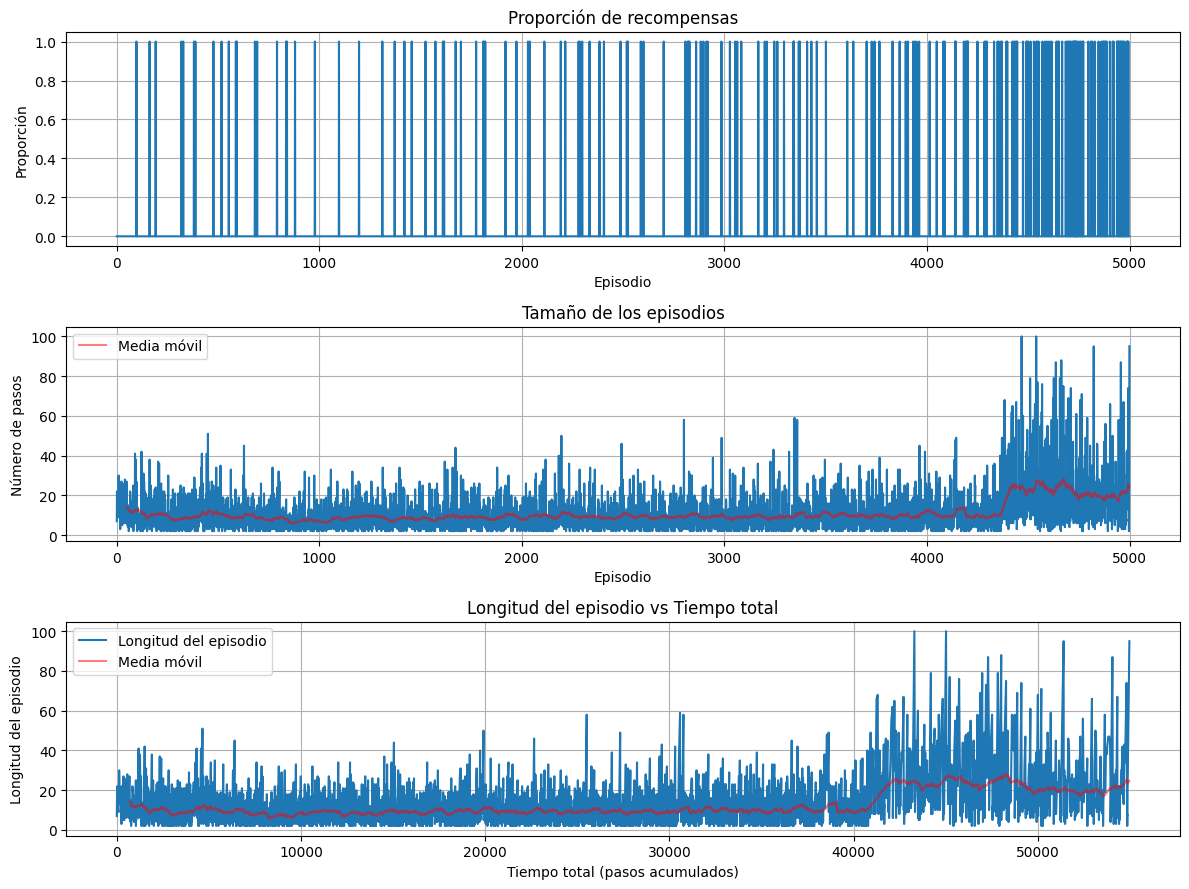

In [117]:
plot_learning_analysis(rewards_per_episode, episodes_sizes)

In [118]:
# Función para evaluar el rendimiento
def evaluate_agent(env, Q, n_episodes=100):
    total_rewards = []
    for _ in range(n_episodes):
        state, _ = env.reset(seed=100)
        episode_reward = 0
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

In [119]:
# Evaluamos el agente
mean_reward = evaluate_agent(env, agent.Q)
print(f"\nRecompensa promedio en evaluación: {mean_reward}")


Recompensa promedio en evaluación: 0.0


In [120]:
# Política Greedy a partir de los valores Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    frames = []
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed=100)  # start in top-left, = 0
    img = env.render()
    frames.append(img)
    actions = ""
    
    while not done:
        # Obtener los valores Q para el estado actual y encontrar la mejor acción
        q_values = Q[state]  # Q es un defaultdict, esto retorna el array de valores para el estado
        action = np.argmax(q_values)
        
        # Registrar la acción
        actions += f"{action}, "
        pi_star[state, action] = action
        
        # Ejecutar la acción en el ambiente
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
    
    return pi_star, actions, frames

In [121]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions, frames = pi_star_from_Q(env, agent.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 3.]
 [0. 0. 0. 3.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 3, 3, 3, 0, 2,  
 Para el siguiente grid
 [[[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]

 [[180 200 230]
  [204 230 255]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [204 230 255]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 ...

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [235 245 249]
  [180 200 230]]

 [[180 200 230]
  [235 245 249]
  [235 245 249]
  ...
  [204 230 255]
  [204 230 255]
  [180 200 230]]

 [[180 200 230]
  [180 200 230]
  [180 200 230]
  ...
  [180 200 230]
  [180 200 230]
  [180 200 230]]]



In [122]:
from moviepy import ImageSequenceClip  # pip install moviepy
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)
# Example usage
create_gif(frames, "animation.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video animation.mp4.
MoviePy - Writing video animation.mp4



MoviePy - Done !
MoviePy - video ready animation.mp4
